# About

This script compares the performance of the two oracles live on StarkNet for the ETH/USD feed.

Empiric emits events every time a source sends new data on-chain which lets anyone audit their public track record going back months. They have emitted over 6M events to date.

Stork contracts can be benchmarked by repeatedly polling their values. We ran a script that pulled data every 3 minutes (their update frequency) and stored it for analysis.

We compare these two to Coinmarketcap data, which aggregates from many sources. Their data is polled regularly at a frequency greater than the 60 seconds at which they update the data served over their public API.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
time_window = (1660846500, 1661192100) # 96 hours (4 days)

In [28]:
stork = pd.read_csv("../data/stork_data.csv")
stork = stork.drop(columns="Unnamed: 0")
stork = stork.drop_duplicates().reset_index(drop=True)
stork["datetime"] = pd.to_datetime(stork["timestamp"], unit="s")
stork["value"] = stork["value"].apply(lambda x: float(x)/(10**18))
stork = stork[(stork["timestamp"] > time_window[0]) & (stork["timestamp"] <= time_window[1])].reset_index(drop=True)
stork.head()

,asset,value,timestamp,publisher,type,datetime


In [29]:
len(stork)

0

As far as we can tell, Stork was down during this entire 96 hour window. By the end of the window of analysis, the last update was more than 5 days old.

In [32]:
empiric = pd.read_csv("../data/empiric-events.csv")
empiric = empiric.drop(columns="Unnamed: 0")
empiric["datetime"] = pd.to_datetime(empiric["datetime"])
empiric = empiric[empiric["key"] == "eth/usd"]
empiric.loc[:, ["transaction_hash",]] = empiric["transaction_hash"].apply(lambda x: hex(int(x)))
empiric = empiric[(empiric["timestamp"] > time_window[0]) & (empiric["timestamp"] <= time_window[1])].reset_index(drop=True)
empiric.head()

,key,value,source,publisher,timestamp,transaction_hash,datetime
0,eth/usd,1867.59,gemini,empiric,1660846521,0x259b3b86f4f16914f3515b5a50779b99a185908cbd3b...,2022-08-18 18:15:21
1,eth/usd,1867.59,gemini,equilibrium,1660846522,0x4816653544f2f2bfaa86e1b543c84c7ff99bad26dcb2...,2022-08-18 18:15:22
2,eth/usd,1866.80,ftx,empiric,1660846523,0x73da874e10f2767eac67ce26e45d679ca855255162ab...,2022-08-18 18:15:23
3,eth/usd,1866.80,ftx,equilibrium,1660846526,0x5556138f64378c9772dd1c2d704e3d1ebb96405e15ee...,2022-08-18 18:15:26
4,eth/usd,1869.35,cex,empiric,1660846527,0x520ce31ddf0d2640577ca23e4f3d01a402232bcaada9...,2022-08-18 18:15:27


In [33]:
len(empiric)

76882

In [34]:
coinmarketcap = pd.read_csv("../data/coinmarketcap_data.csv")
coinmarketcap = coinmarketcap.drop(columns="Unnamed: 0")
coinmarketcap["datetime"] = pd.to_datetime(coinmarketcap["timestamp"], unit="s")
coinmarketcap = coinmarketcap.drop_duplicates().reset_index(drop=True)
coinmarketcap = coinmarketcap[(coinmarketcap["timestamp"] > time_window[0]) & (coinmarketcap["timestamp"] <= time_window[1])].reset_index(drop=True)
coinmarketcap.head()

,value,timestamp,datetime
0,1866.828253,1660846560,2022-08-18 18:16:00
1,1866.154332,1660846620,2022-08-18 18:17:00
2,1866.155946,1660846680,2022-08-18 18:18:00
3,1865.974650,1660846740,2022-08-18 18:19:00
4,1865.737513,1660846800,2022-08-18 18:20:00


In [35]:
datasets = [(empiric, "Empiric"), (coinmarketcap, "Coinmarketcap")]

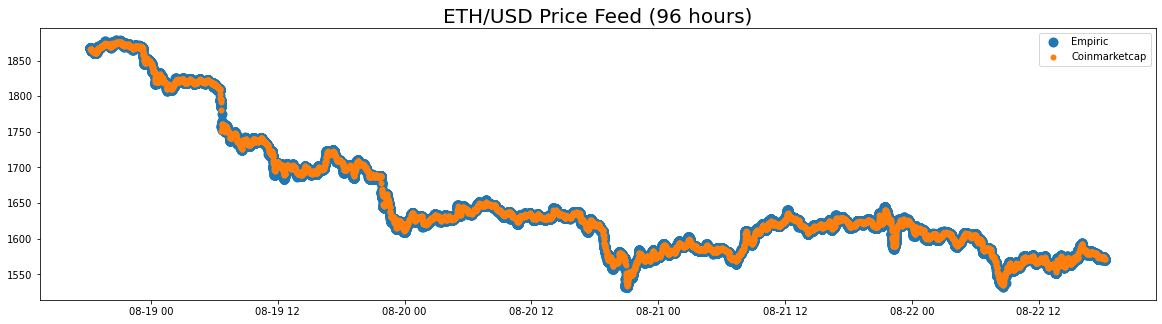

In [137]:
plt.figure(figsize=(20, 5))
for dataset, label in datasets:
    key = "current_median" if label == "Empiric" else "value"
    linewidths = 4 if label == "Empiric" else 0.01
    plt.scatter(dataset["datetime"], dataset[key], label=label, linewidths=linewidths)

plt.title("ETH/USD Price Feed (96 hours)", fontsize=20)
plt.legend()
plt.show()

In [39]:
# Need to aggregate - take the median of all the values currently available

from statistics import median

publisher_values = {}
empiric["current_median"] = 0
for i, row in empiric.iterrows():
    publisher_values[row["source"]] = row["value"]
    empiric.loc[i, "current_median"] = median(publisher_values.values())

In [40]:
# Then find the Coinmarketcap datapoint for benchmarking precision
coinmarketcap = coinmarketcap.sort_values("timestamp").reset_index(drop=True)
empiric["last_coinmarketcap_timestamp"] = 0
last_coinmarketcap_timestamp_index = 0
last_coinmarketcap_timestamp = coinmarketcap.loc[last_coinmarketcap_timestamp_index, "timestamp"]
for i, row in empiric.iterrows():
    if last_coinmarketcap_timestamp > time_window[1] or last_coinmarketcap_timestamp_index+1 >= len(coinmarketcap):
        break # Reached end of time window
    if row["timestamp"] > coinmarketcap.loc[last_coinmarketcap_timestamp_index+1, "timestamp"]: # Move on to next timestamp
        last_coinmarketcap_timestamp_index += 1
        last_coinmarketcap_timestamp = coinmarketcap.loc[last_coinmarketcap_timestamp_index, "timestamp"]

    empiric.loc[i, "last_coinmarketcap_timestamp"] = last_coinmarketcap_timestamp


In [104]:
combined_empiric = pd.merge(coinmarketcap, empiric, left_on='timestamp', right_on="last_coinmarketcap_timestamp", how='inner', suffixes=["_coinmarketcap", "_empiric"])
combined_empiric["difference"] = combined_empiric["current_median"] - combined_empiric["value_coinmarketcap"]
combined_empiric["percentage_difference"] = combined_empiric["difference"] / combined_empiric["value_coinmarketcap"]
combined_empiric = combined_empiric[combined_empiric["timestamp_coinmarketcap"] < combined_empiric["timestamp_empiric"]]
combined_empiric

,value_coinmarketcap,timestamp_coinmarketcap,datetime_coinmarketcap,key,value_empiric,source,publisher,timestamp_empiric,transaction_hash,datetime_empiric,current_median,last_coinmarketcap_timestamp,difference,percentage_difference
15,1866.828253,1660846560,2022-08-18 18:16:00,eth/usd,1867.960000,cryptowatch-coinbase-pro,braavos,1660846566,0x20e2ea75a319d5ce5e7fe69f71b0f15a983ea4e543a1...,2022-08-18 18:16:06,1867.345,1660846560,0.516747,0.000277
16,1866.828253,1660846560,2022-08-18 18:16:00,eth/usd,1867.290000,cryptowatch-kraken,braavos,1660846566,0x20e2ea75a319d5ce5e7fe69f71b0f15a983ea4e543a1...,2022-08-18 18:16:06,1867.345,1660846560,0.516747,0.000277
17,1866.828253,1660846560,2022-08-18 18:16:00,eth/usd,1867.890000,cryptowatch-binance,braavos,1660846566,0x20e2ea75a319d5ce5e7fe69f71b0f15a983ea4e543a1...,2022-08-18 18:16:06,1867.345,1660846560,0.516747,0.000277
18,1866.828253,1660846560,2022-08-18 18:16:00,eth/usd,1867.000000,cryptowatch-bitfinex,braavos,1660846566,0x20e2ea75a319d5ce5e7fe69f71b0f15a983ea4e543a1...,2022-08-18 18:16:06,1867.345,1660846560,0.516747,0.000277
19,1866.828253,1660846560,2022-08-18 18:16:00,eth/usd,1865.230000,gemini,empiric,1660846578,0x231fa3ab565afc7a325d889a085e3ec9f7dba3a49c44...,2022-08-18 18:16:18,1867.345,1660846560,0.516747,0.000277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76873,1571.939843,1661192040,2022-08-22 18:14:00,eth/usd,1571.105299,cryptowatch-bitfinex,braavos,1661192070,0x7c9e8af3fbd6722d16ccab137f5ec4c3b71f5faa8920...,2022-08-22 18:14:30,1570.710,1661192040,-1.229843,-0.000782
76874,1571.939843,1661192040,2022-08-22 18:14:00,eth/usd,1570.030000,cryptowatch-coinbase-pro,empiric,1661192076,0x4dba24cdb25cbe1a417b6b96cb5b9e00a355ac39b80a...,2022-08-22 18:14:36,1570.710,1661192040,-1.229843,-0.000782
76875,1571.939843,1661192040,2022-08-22 18:14:00,eth/usd,1570.710000,cryptowatch-kraken,empiric,1661192076,0x4dba24cdb25cbe1a417b6b96cb5b9e00a355ac39b80a...,2022-08-22 18:14:36,1570.710,1661192040,-1.229843,-0.000782
76876,1571.939843,1661192040,2022-08-22 18:14:00,eth/usd,1570.540000,cryptowatch-binance,empiric,1661192076,0x4dba24cdb25cbe1a417b6b96cb5b9e00a355ac39b80a...,2022-08-22 18:14:36,1570.710,1661192040,-1.229843,-0.000782


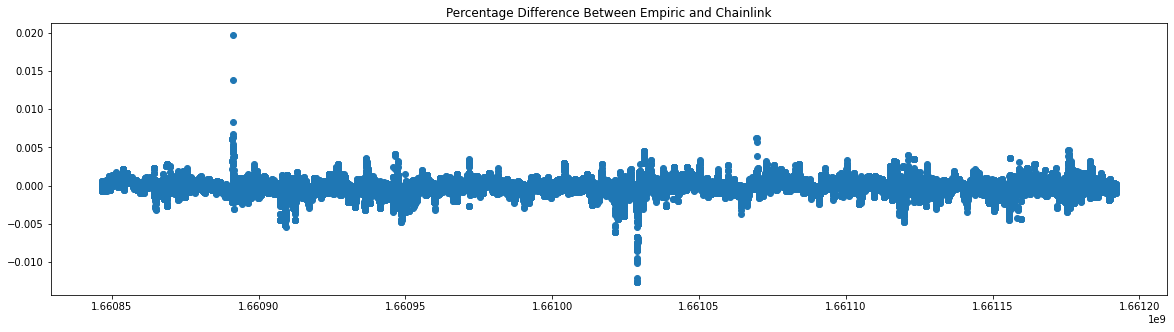

In [138]:
plt.figure(figsize=(20, 5))
plt.scatter(combined_empiric["timestamp_empiric"], combined_empiric["percentage_difference"])
plt.title("Percentage Difference Between Empiric and Chainlink")
plt.show()

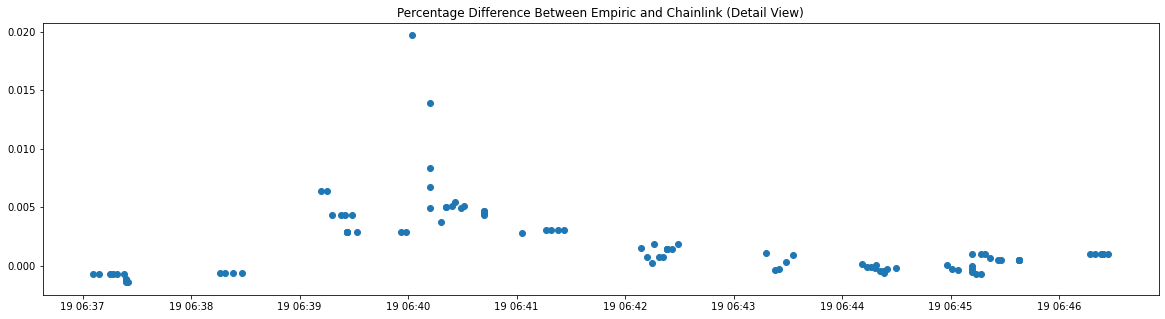

In [140]:
plt.figure(figsize=(20, 5))
subset = combined_empiric[(combined_empiric["timestamp_empiric"] > 1660891000) & (combined_empiric["timestamp_empiric"] < 1660891600)]
plt.scatter(subset["datetime_empiric"], subset["percentage_difference"])
plt.title("Percentage Difference Between Empiric and Chainlink (Detail View)")
plt.show()

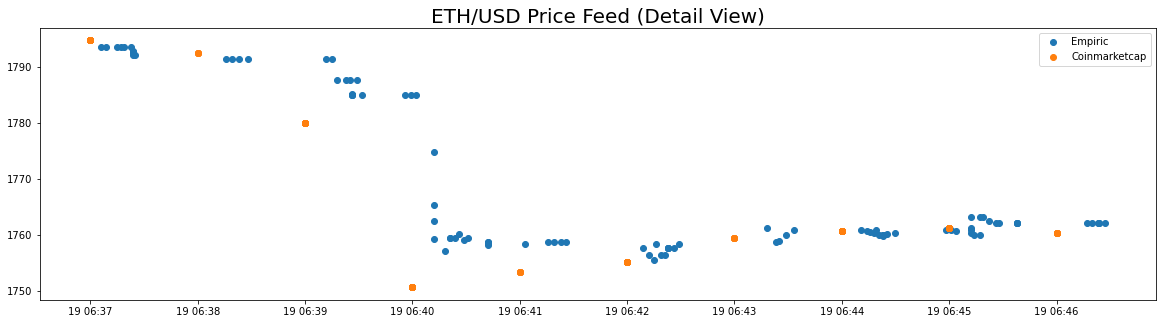

In [142]:
plt.figure(figsize=(20, 5))
subset = combined_empiric[(combined_empiric["timestamp_empiric"] > 1660891000) & (combined_empiric["timestamp_empiric"] < 1660891600)]
plt.scatter(subset["datetime_empiric"], subset["current_median"], label="Empiric")
plt.scatter(subset["datetime_coinmarketcap"], subset["value_coinmarketcap"], label="Coinmarketcap")
plt.title("ETH/USD Price Feed (Detail View)", fontsize=20)
plt.legend()
plt.show()

In [148]:
subset = combined_empiric[(combined_empiric["timestamp_empiric"] > 1660891000) & (combined_empiric["timestamp_empiric"] < 1660891240)]
subset.sort_values("timestamp_empiric", ascending=True)

,value_coinmarketcap,timestamp_coinmarketcap,datetime_coinmarketcap,key,value_empiric,source,publisher,timestamp_empiric,transaction_hash,datetime_empiric,current_median,last_coinmarketcap_timestamp,difference,percentage_difference
9536,1779.966495,1660891140,2022-08-19 06:39:00,eth/usd,1746.34,gemini,argent,1660891152,0x2c6a29c4e0364a6b77679461514fa8f899a18983dd28...,2022-08-19 06:39:12,1791.4075,1660891140,11.441005,0.006428
9537,1779.966495,1660891140,2022-08-19 06:39:00,eth/usd,1749.30,cex,argent,1660891155,0x56940a30d19d27f0efc74078d88c694a3c1ef10e47c2...,2022-08-19 06:39:15,1791.4075,1660891140,11.441005,0.006428
9539,1779.966495,1660891140,2022-08-19 06:39:00,eth/usd,1752.30,bitstamp,argent,1660891158,0x6da217c42f73385ec4b284ec7d926878fa59427d2ee9...,2022-08-19 06:39:18,1787.7475,1660891140,7.781005,0.004371
9540,1779.966495,1660891140,2022-08-19 06:39:00,eth/usd,1754.10,gemini,empiric,1660891163,0x5c8df4ebdb5176c90c83da5bf7010e4d02788f26e198...,2022-08-19 06:39:23,1787.7475,1660891140,7.781005,0.004371
9541,1779.966495,1660891140,2022-08-19 06:39:00,eth/usd,1734.00,ftx,empiric,1660891165,0x6df4509fadaa4dc0a096e98ed90d0be940dae8b66023...,2022-08-19 06:39:25,1787.7475,1660891140,7.781005,0.004371
9543,1779.966495,1660891140,2022-08-19 06:39:00,eth/usd,1786.99,cryptowatch-coinbase-pro,argent,1660891166,0x4d775587d8a572bfe8f4a38c6e8f9d5480aef3732aa2...,2022-08-19 06:39:26,1785.1725,1660891140,5.206005,0.002925
9544,1779.966495,1660891140,2022-08-19 06:39:00,eth/usd,1786.75,cryptowatch-kraken,argent,1660891166,0x4d775587d8a572bfe8f4a38c6e8f9d5480aef3732aa2...,2022-08-19 06:39:26,1785.0525,1660891140,5.086005,0.002857
9545,1779.966495,1660891140,2022-08-19 06:39:00,eth/usd,1786.76,cryptowatch-binance,argent,1660891166,0x4d775587d8a572bfe8f4a38c6e8f9d5480aef3732aa2...,2022-08-19 06:39:26,1785.0525,1660891140,5.086005,0.002857
9546,1779.966495,1660891140,2022-08-19 06:39:00,eth/usd,1786.90,cryptowatch-bitfinex,argent,1660891166,0x4d775587d8a572bfe8f4a38c6e8f9d5480aef3732aa2...,2022-08-19 06:39:26,1785.0525,1660891140,5.086005,0.002857
9542,1779.966495,1660891140,2022-08-19 06:39:00,eth/usd,1752.05,cex,empiric,1660891169,0x29ae2937b79c43a396395ef7bcd1ab03bb1f098ec8c4...,2022-08-19 06:39:29,1787.7475,1660891140,7.781005,0.004371


In [163]:
subset = combined_empiric[(combined_empiric["timestamp_empiric"] > 1660850000) & (combined_empiric["timestamp_empiric"] < 1660891240)]
publisher_values = {}
for i, row in subset.iterrows():
    publisher_values[row["source"]] = row["value_empiric"]
    timestamp = subset.loc[i, "timestamp_empiric"]
    if timestamp >= 1660891000:
        print("current_median", timestamp, median(publisher_values.values()), publisher_values)

current_median 1660891026 1793.44 {'gemini': 1788.0700000000002, 'ftx': 1793.3, 'cex': 1791.79, 'bitstamp': 1788.1, 'cryptowatch-coinbase-pro': 1793.71, 'cryptowatch-kraken': 1795.33, 'cryptowatch-binance': 1793.44, 'cryptowatch-bitfinex': 1794.0, 'coingecko': 1812.82}
current_median 1660891029 1793.44 {'gemini': 1788.0700000000002, 'ftx': 1793.3, 'cex': 1788.32, 'bitstamp': 1788.1, 'cryptowatch-coinbase-pro': 1793.71, 'cryptowatch-kraken': 1795.33, 'cryptowatch-binance': 1793.44, 'cryptowatch-bitfinex': 1794.0, 'coingecko': 1812.82}
current_median 1660891037 1793.44 {'gemini': 1787.25, 'ftx': 1793.3, 'cex': 1788.32, 'bitstamp': 1788.1, 'cryptowatch-coinbase-pro': 1793.71, 'cryptowatch-kraken': 1795.33, 'cryptowatch-binance': 1793.44, 'cryptowatch-bitfinex': 1794.0, 'coingecko': 1812.82}
current_median 1660891035 1793.44 {'gemini': 1787.25, 'ftx': 1793.3, 'cex': 1788.32, 'bitstamp': 1787.0, 'cryptowatch-coinbase-pro': 1793.71, 'cryptowatch-kraken': 1795.33, 'cryptowatch-binance': 1793.